# 0 - Configuration

## 0.0 - Create Samples

In [1]:
# import pandas as pd
# import datetime
# billboard_charts = pd.read_csv(r'C:\Users\Xonas\Documents\UFPB\IA-MUSIC\data\billboard_hot100_charts.csv', sep="\t")
# # billboard_charts.info()
# billboard_spotify_charts = pd.read_csv(r'C:\Users\Xonas\Documents\UFPB\IA-MUSIC\data\billboard_hot100_songs_to_spotify_with_features.csv', sep="\t")
# # billboard_spotify_charts.info()
# sucess = billboard_charts[billboard_charts['chart_pos']<=5].drop_duplicates(subset='track')
# fail = billboard_charts[~billboard_charts['track'].isin(sucess['track'])].drop_duplicates(subset='track')

# sucess.loc[:, 'chart_week'] = pd.to_datetime(sucess['chart_week'], format='%Y-%m-%d')
# fail.loc[:, 'chart_week'] = pd.to_datetime(fail['chart_week'], format='%Y-%m-%d')

# #sample de 15 anos
# sucess_sample = sucess[(sucess['chart_week']<datetime.datetime(2021, 12, 31)) & (sucess['chart_week']>datetime.datetime(2006, 1, 1))]
# # sucess_sample.info()
# fail_sample = fail[(fail['chart_week']<datetime.datetime(2021, 12, 31)) & (fail['chart_week']>datetime.datetime(2006, 1, 1))].sample(len(sucess_sample))

# # len(sucess_sample), len(fail_sample)
# sucess_sample.to_csv('../data/sucess_sample.csv', index=False)
# fail_sample.to_csv('../data/fail_sample.csv', index=False)
# # sucess[sucess['chart_week']].info()
# # fail.info()
# sucess_sample

## 0.1 - Downloads musics

In [2]:
import pandas as pd
sucess = pd.read_csv('../data/sucess_sample.csv')
sucess.head(2)

fail = pd.read_csv('../data/fail_sample.csv')

In [4]:
import os
from youtube_search import YoutubeSearch
from pathlib import Path
import re
from IPython.display import clear_output


def download(track, artist, locate)-> None:

    # Limpa os nomes
    artistclean = re.sub(r"[^a-zA-Z0-9]", "_",artist)
    trackclean = re.sub(r"[^a-zA-Z0-9]", "_",track)
    filename = f"{trackclean}_{artistclean}"
    if Path(f"{locate}/{filename}.mp3").is_file():
        return None
    print(filename)
    # Pesquisa no YouTube
    search_query = track + " - " + artist
    results = YoutubeSearch(search_query, max_results=1).to_dict()
    if not results:
        print(f"Nenhum resultado encontrado para {search_query}")

    url_ = "https://www.youtube.com" + results[0]['url_suffix']
    
    # Define caminhos
    webm_path = f"{locate}/{filename}.webm"
    mp3_path = f"{locate}/{filename}.mp3"
    
    # Baixa o arquivo .webm
    !yt-dlp -f bestaudio -o "{webm_path}" "{url_}"

    # Converte para .mp3
    !ffmpeg -i "{webm_path}" -vn -ab 192k -ar 44100 -y "{mp3_path}"

    #limpar o terminal
    clear_output()

    # (Opcional) Remove o arquivo .webm após conversão
    if Path(webm_path).is_file():
        os.remove(webm_path)


In [4]:
sucess.apply(lambda x: download(x['track'], x['artist'], '../data/musics'), axis= 1)

0      None
1      None
2      None
3      None
4      None
       ... 
480    None
481    None
482    None
483    None
484    None
Length: 485, dtype: object

In [ ]:
fail.apply(lambda x: download(x['track'], x['artist'], '../data/musics'), axis= 1)

Here_For_A_Good_Time_George_Strait


In [6]:
def file_name(artist, track):
    artistclean = re.sub(r"[^a-zA-Z0-9]", "_",artist)
    trackclean = re.sub(r"[^a-zA-Z0-9]", "_",track)
    return f"{trackclean}_{artistclean}"

sucess.loc[:,'file_name'] = sucess.apply(lambda x: file_name(x['artist'], x['track']), axis=1)
fail.loc[:,'file_name'] = fail.apply(lambda x: file_name(x['artist'], x['track']), axis=1)

In [12]:
a = [1,2,3,4,5]
5 in a

True

In [39]:
list_dir = os.listdir('../data/musics')

files_downloaded = list(sucess['file_name'].values) + list(fail['file_name'].values)

for files in files_downloaded:
    if files+'.mp3' not in list_dir:
        if files in sucess['file_name'].values:
            print('sucess:' , files)
        if files in fail['file_name'].values:
            print('fail:' , files)

fail: Confessions_Of_A_Dangerous_Mind_Logic
fail: Bad_Habits_Maxwell
fail: Studio_ScHoolboy_Q_Featuring_BJ_The_Chicago_Kid
fail: F_ckwithmeyouknowigotit_Jay_Z_Featuring_Rick_Ross


## 0.2 Transform in spectogram

KeyboardInterrupt: 

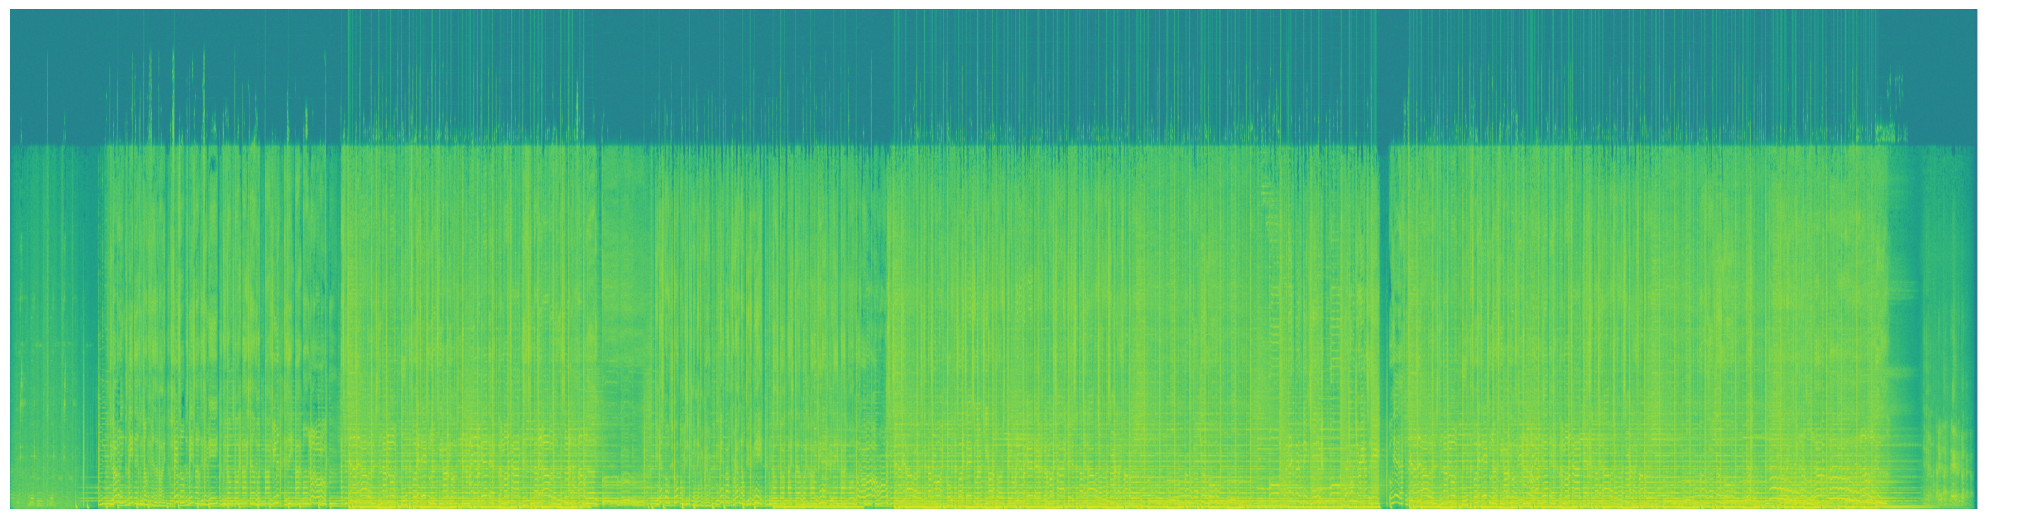

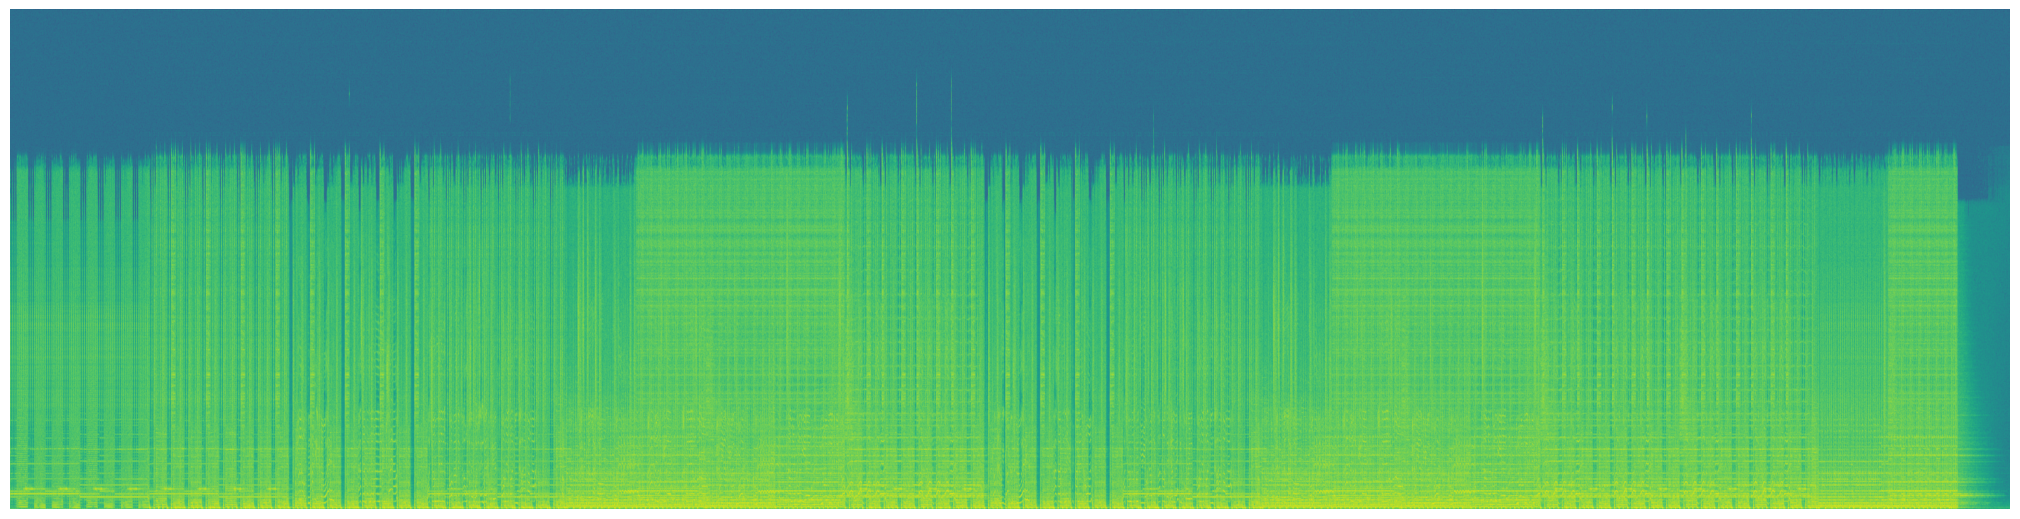

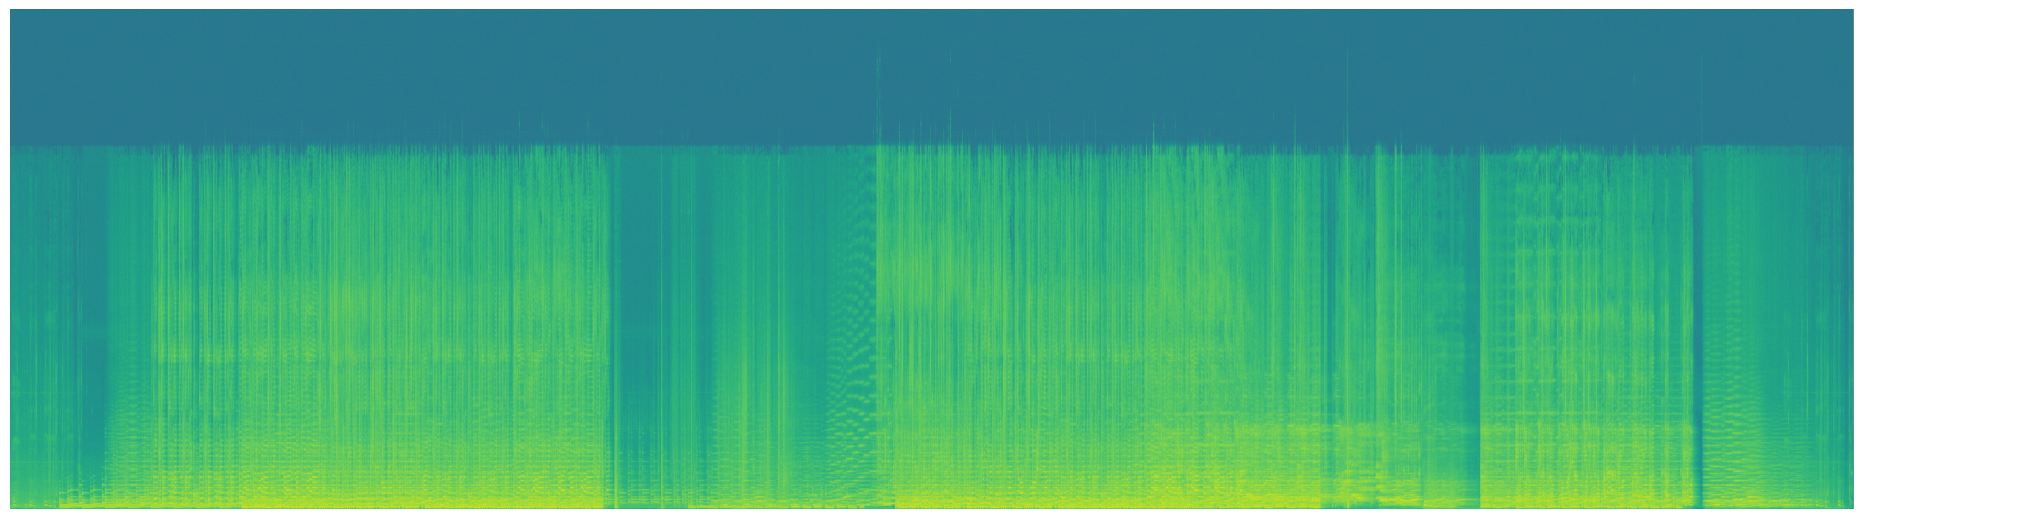

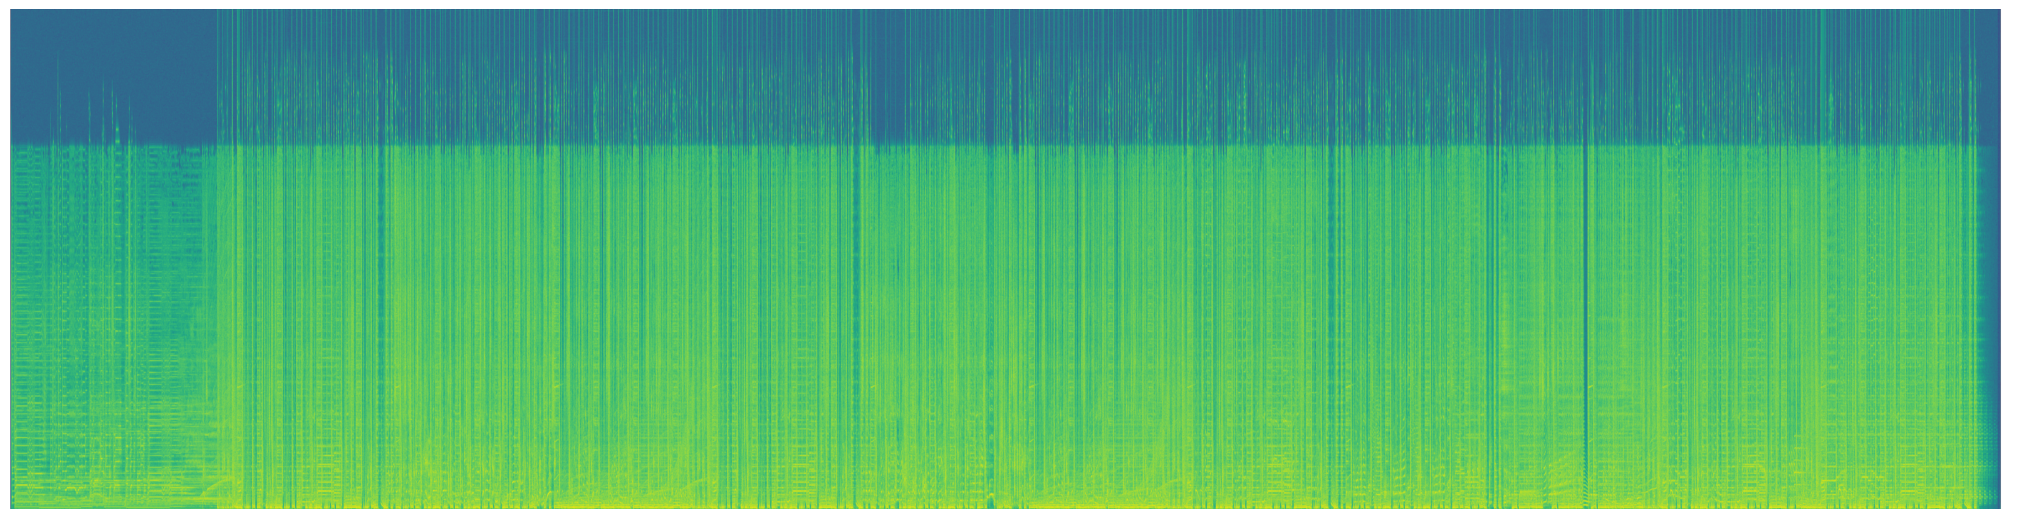

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pydub import AudioSegment
from scipy.io import wavfile
import tempfile
from pathlib import Path

def create_spectrogram(mp3_filepath):
    file_name = Path(mp3_filepath).name
    if Path('../data/spectogramas2/'+file_name.split('.')[0]+'.png').is_file():
        return None
    
    try:
        mp3_audio = AudioSegment.from_mp3(mp3_filepath)
    except Exception as e:
        print(f"Error loading MP3 file: {e}")
        return

    with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as temp_wav_file:
        temp_wav_filename = temp_wav_file.name
        mp3_audio.export(temp_wav_filename, format='wav')
        
        sample_rate, audio_data = wavfile.read(temp_wav_filename)

    if audio_data.ndim == 2:
        audio_data = audio_data.mean(axis=1)  # Convert stereo to mono

    fig, ax = plt.subplots(figsize=(30, 5))
    ax.specgram(audio_data, Fs=sample_rate, NFFT=2048, noverlap=1024, cmap='viridis') 
    ax.axis('off')  # Remove axes
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove borders/margins
    plt.savefig('../data/spectogramas2/'+file_name.split('.')[0])

if __name__ == '__main__':
    for music in Path('../data/musics/').iterdir():
        create_spectrogram(music)
